In [1]:
clear
save_figures = 1;

In [2]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "the_notebook = " + "'"+thename+"'";
kernel.execute(command);
var command = "the_kernel = " + "'"+kernel.name+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

The following was generated from a Jupyter notebook with the following filename and kernel.

In [3]:
disp(['notebook filename: ',the_notebook,'.ipynb'])
disp(['notebook kernel: ',the_kernel])

notebook filename: _source_and_docs.ipynb
notebook kernel: matlab


# `tf_factor` docs

The following is the source code. Executing the cell writes the source file!

In [5]:
%%file ../tf_factor.m
function out = tf_factor(sys)
% TF_FACTOR  factors a transfer function TF object
%   SYS_ARRAY = TF_FACTOR(SYS) factors SYS into
%   constant, real pole/zero, and 
%   conjugate pole/zero pair sub-TF models. 
%   It returns a TF model array. 
%   The last entry is the appropriate gain.
%   The product of entries of the model array 
%   should equal sys.
%   
%   Dependencies:
%     - matlab-rico functions
%       - POLE 
%       - ZERO
%     - toolboxes
%       - Control Systems
%
%   Example:
%
%   sys=tf(...
%     [-0.64 -0.4101 0.00783],...
%     [1 1.489 0.7681 0.09455 0.0424 .7]...
%   );
%   tf_factor(sys)
%   
%   source: https://github.com/ricopicone/matlab-rico
%   
%   See also TF, STACK.

if ~isa(sys,'tf')
  sys = tf(sys);
end

% extract poles and zeros
poles=pole(sys);
zeros=zero(sys);

% make sure they're in coupled pairs
poles_cplx = cplxpair(poles);
zeros_cplx = cplxpair(zeros);

% loop through and extract sub-tfs into model array, each in standard form, keeping track of the gain
F = stack(1,tf(1,1)); % init model array
F_gain = sys.Num{:}(...
  find(cell2mat(sys.Num),1,'first')...
); % overall gain of stack
F_gain_o = F_gain ; % original gain
k=1;
jskip=0;
% poles first
for j=1:length(poles_cplx)
  if ~jskip
    if ~isreal(poles_cplx(j))
      F(:,:,k) = zpk([],[poles_cplx(j),poles_cplx(j+1)],poles_cplx(j)*poles_cplx(j+1));
      F_gain = F_gain/abs(poles_cplx(j)*poles_cplx(j+1));
      jskip=1;% skip next index
    else
      F(:,:,k) = zpk([],poles_cplx(j),abs(poles_cplx(j)));
      F_gain = F_gain/abs(poles_cplx(j));
      jskip=0;
    end
    k=k+1;
  else
    jskip=0;
  end
end
% now zeros
for j=1:length(zeros_cplx)
  if ~jskip
    if ~isreal(zeros_cplx(j))
      F(:,:,k) = zpk([zeros_cplx(j),zeros_cplx(j+1)],[],1/(zeros_cplx(j)*zeros_cplx(j+1)));
      F_gain = F_gain*abs(zeros_cplx(j)*zeros_cplx(j+1));
      jskip=1;% skip next index
    else
      F(:,:,k) = zpk(zeros_cplx(j),[],1/abs(zeros_cplx(j)));
      F_gain = F_gain*abs(zeros_cplx(j));
      jskip=0;
    end
    k=k+1;
  else
    jskip=0;
  end
end
F(:,:,k) = F_gain; % drop the overall gain into the model array

% check by concatenation
tf_composite = 1;
for j=1:k
  tf_composite = tf_composite*F(:,:,j);
end

if (... % check that the factorization is correct
  isequal(sys.Num{:}(find(cell2mat(tf_composite.Num),1,'first')),F_gain_o) && ... % gain
  round(sum(poles),5) == round(sum(pole(tf_composite)),5) && ... % poles ... not perfect
  round(sum(zeros),5) == round(sum(zero(tf_composite)),5) ... % zeros ... not perfect
)
  out = F;
else
  error('composite check failed!')
  out = 1;
end

Created file '/Users/picone/code/matlab-rico/tf_factor.m'.


## Usage and examples

# `bode_multi` docs

The following is the source code. Executing the cell writes the source file!

In [6]:
%%file ../bode_multi.m
function [out,ax1,ax2] = bode_multi(sys_a)

syms s

if ~isa(sys_a,'tf')
  sys_a = tf(sys_a);
end
n = length(sys_a); % > 1 if system model array

out = figure;
ax1 = subplot(2,1,1);
ax2 = subplot(2,1,2);
omega_a = {.1,1};
mag_lims = [0,1];
phase_lims = [-90,0];
for i = 1:n
  sys = sys_a(1,1,i);
  [mag,phase,omega] = bode(sys);
  if omega(1) < omega_a{1}
    omega_a{1} = omega(1);
  end
  if omega(end) > omega_a{end}
    omega_a{end} = omega(end);
  end
  if mag_lims(1) < mag_lims(1)
    mag_lims(1) = mag_lims(1);
  end
  if mag_lims(2) > mag_lims(2)
    mag_lims(2) = mag_lims(2);
  end
  if phase_lims(1) < phase_lims(1)
    phase_lims(1) = phase_lims(1);
  end
  if phase_lims(2) > phase_lims(2)
    phase_lims(2) = phase_lims(2);
  end
end

olog = num2cell(cellfun(@(x) log10(x),omega_a));
omega = logspace(olog{:},100);

for i = 1:n
  sys = sys_a(1,1,i);
  [mag,phase] = bode(sys,omega);
  mag = squeeze(mag);
  phase = squeeze(phase);
  % size(omega)
  % omega = squeeze(omega);
  axes(ax1);
  hold on;
  [num,den] = tfdata(sys);
  sys_sym = poly2sym(cell2mat(num),s)/poly2sym(cell2mat(den),s);
  semilogx(...
    omega,db(mag),...
    'linewidth',1,...
    'displayname',['$',latex(sys_sym),'$']...
  );
  ylabel('|H(j\omega)|, dB')
  axes(ax2);
  hold on;
  semilogx(omega,phase,'linewidth',1);
  xlabel('frequency \omega, rad/s')
  ylabel('\angle{H(j\omega)}, deg')
  h = findobj(gcf,'type','line');
  set(h,'linewidth',1);
end
% log scale
ax1.XScale = 'log';
ax2.XScale = 'log';
% adjust limits and ticks
mag_tick_array = ax1.YLim(1):20:ax1.YLim(2);
[m0db,i0db_a] = min(abs(mag_tick_array));
i0db = i0db_a(1); % first index closest to zero
mag_tick_array = mag_tick_array-mag_tick_array(i0db);
ax1.YTick = mag_tick_array;
phase_tick_array = ax2.YLim(1):45:ax2.YLim(2);
[p0db,i0_a] = min(abs(phase_tick_array));
i0 = i0_a(1); % first index closest to zero
phase_tick_array = phase_tick_array-phase_tick_array(i0);
ax2.YTick = phase_tick_array;
% grid lines
ax1.XGrid = 'on';
ax1.YGrid = 'on';
ax2.XGrid = 'on';
ax2.YGrid = 'on';
% legend
axP = get(ax1,'Position'); % so we can keep size
l = legend(ax1,'show');
l.Interpreter = 'latex';
l.Location = 'northeastoutside';
ax1.Position = axP; % reset size

Created file '/Users/picone/code/matlab-rico/bode_multi.m'.


## Usage and examples

In [7]:
sys = tf([5,3,5],[1,6,1,20])


sys =
 
    5 s^2 + 3 s + 5
  --------------------
  s^3 + 6 s^2 + s + 20
 
Continuous-time transfer function.



In [8]:
sys_a = tf_factor(sys)


sys_a(:,:,1,1) =
 
          3.155
  ----------------------
  s^2 - 0.3399 s + 3.155
 

sys_a(:,:,2,1) =
 
    6.34
  --------
  s + 6.34
 

sys_a(:,:,3,1) =
 
  s^2 + 0.6 s + 1
 

sys_a(:,:,4,1) =
 
  0.25
 
4x1 array of continuous-time transfer functions.



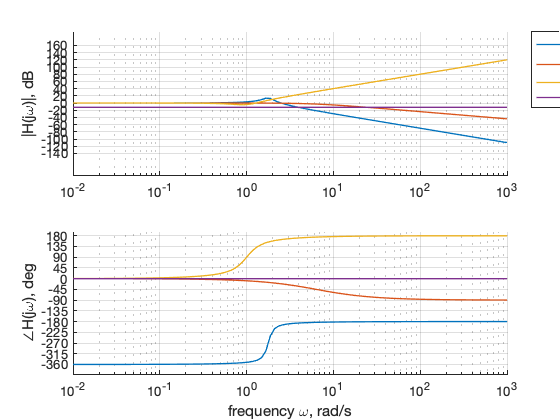

In [13]:
% [f,ax_mag,ax_phase] = bode_multi(G); % get axis handles
f = bode_multi(sys_a);

hgsave(f,'figures/temp');

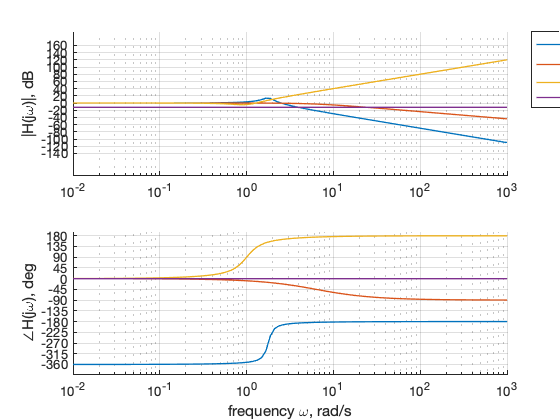

In [14]:
if save_figures
  fn = 'bode_multi_docs.tex';
  h = hgload('figures/temp');
  cleanfigure;
  matlab2tikz(['figures/',fn],...
    'figurehandle',h,...
    'width','.9\linewidth',...
    'height','.5\linewidth',...
    'extraAxisOptions',...
    [...
      'scaled ticks=false,',... 
      'tick label style={/pgf/number format/fixed}'...
    ],...
    'showInfo', false...
  );
end

# `pole` docs

The following is the source code. Executing the cell writes the source file!

In [15]:
%%file ../pole.m
function out = pole(sys)

out = roots(cell2mat(sys.Den));

Created file '/Users/picone/code/matlab-rico/pole.m'.


## Usage and examples

# `zero` docs

The following is the source code. Executing the cell writes the source file!

In [16]:
%%file ../zero.m
function out = zero(sys)

out = roots(cell2mat(sys.Num));

Created file '/Users/picone/code/matlab-rico/zero.m'.


## Usage and examples

# `tf2latex` docs

The following is the source code. Executing the cell writes the source file!

In [18]:
%%file ../tf2latex.m

function out = tf2latex(sys)
% TF2LATEX  converts tf model to LaTeX code
%   TEXT = TF2LATEX(SYS) converts the
%   tf model SYS to LaTeX text.
%   Dependencies: 
%     - toolboxes
%       - Control Systems
%       - Symbolic

syms s

num = sys.Numerator;
den = sys.Denominator;

out = latex(...
  poly2sym(...
    cell2mat(num),...
    s...
  )/...
  poly2sym(...
    cell2mat(den),...
    s...
  )...
);

Created file '/Users/picone/code/matlab-rico/tf2latex.m'.


## Usage and examples